In [ ]:
# ===== [1] 설치 및 기본 설정 =====
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

import os
import numpy as np
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00
✅ Using device: cuda
✅ GPU: NVIDIA L4


In [ ]:
# ===== [2] Google Drive 마운트 & 압축 해제 =====
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive'
dataset_path = '/content/dataset'
os.makedirs(dataset_path, exist_ok=True)

print("📦 Train 압축 해제 중...")
!unzip -q "{drive_path}/train_dataset.zip" -d "{dataset_path}/train"
print("✅ Train 완료!")

print("📦 Val 압축 해제 중...")
!unzip -q "{drive_path}/val_dataset.zip" -d "{dataset_path}/val"
print("✅ Val 완료!")

Mounted at /content/drive
📦 Train 압축 해제 중...
✅ Train 완료!
📦 Val 압축 해제 중...
✅ Val 완료!


In [ ]:
# ===== [3] Semantic Mask 생성 =====
CLASS_MAP = {'Background': 0, 'Pollution': 1, 'Damaged': 2, 'Outline': 3}

def create_semantic_mask(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    width, height = data['image_info']['width'], data['image_info']['height']
    mask = np.zeros((height, width), dtype=np.uint8)

    outline = data.get('swelling', {}).get('battery_outline', [])
    if outline:
        points = np.array(outline, dtype=np.float32).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [points], color=3)

    defects = data.get('defects')
    if defects:
        for defect in defects:
            name, points = defect.get('name'), defect.get('points', [])
            if name in CLASS_MAP and points:
                pts = np.array(points, dtype=np.float32).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], color=CLASS_MAP[name])
    return mask

def generate_masks(label_path, mask_path):
    os.makedirs(mask_path, exist_ok=True)
    for f in tqdm(os.listdir(label_path)):
        if f.endswith('.json'):
            mask = create_semantic_mask(os.path.join(label_path, f))
            cv2.imwrite(os.path.join(mask_path, f.replace('.json', '_mask.png')), mask)

train_base = '/content/dataset/train/content/split_dataset/train'
val_base = '/content/dataset/val/content/split_dataset/val'

print("📦 Train Mask 생성...")
generate_masks(f'{train_base}/labels', f'{train_base}/semantic_masks')
print("📦 Val Mask 생성...")
generate_masks(f'{val_base}/labels', f'{val_base}/semantic_masks')
print("✅ Mask 생성 완료!")

📦 Train Mask 생성...


100%|██████████| 17797/17797 [02:12<00:00, 134.17it/s]


📦 Val Mask 생성...


100%|██████████| 4450/4450 [00:33<00:00, 134.42it/s]

✅ Mask 생성 완료!


In [ ]:
# ===== [4] Dataset & DataLoader (속도 최적화) =====

# ⚡ 속도 최적화 설정
IMG_SIZE = 384      # 512 → 384
BATCH_SIZE = 16     # 8 → 16
NUM_WORKERS = 2     # 4 → 2

class BatteryDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, img_size=384):
        self.image_dir, self.mask_dir = image_dir, mask_dir
        self.transform, self.img_size = transform, img_size
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.images = [f for f in self.images if os.path.exists(os.path.join(mask_dir, f.replace('.png', '_mask.png')))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(os.path.join(self.image_dir, self.images[idx])), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.mask_dir, self.images[idx].replace('.png', '_mask.png')), 0)
        img = cv2.resize(img, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.long()

# Augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.8, 1.2), rotate=(-30, 30), p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=6, p=0.5),
        A.GridDistortion(p=0.5),
    ], p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# DataLoader
train_dataset = BatteryDataset(f'{train_base}/images', f'{train_base}/semantic_masks', train_transform, img_size=IMG_SIZE)
val_dataset = BatteryDataset(f'{val_base}/images', f'{val_base}/semantic_masks', val_transform, img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ Train: {len(train_dataset)}장, {len(train_loader)} batches")
print(f"✅ Val: {len(val_dataset)}장, {len(val_loader)} batches")
print(f"⚡ 최적화: IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}")

✅ Train: 17797장, 1113 batches
✅ Val: 4450장, 279 batches
⚡ 최적화: IMG_SIZE=384, BATCH_SIZE=16


In [ ]:
# ===== [5] 모델 & Loss (속도 최적화) =====

# ⚡ 더 가벼운 Encoder
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b2",  # b4 → b2 (더 빠름)
    encoder_weights="imagenet",
    in_channels=3,
    classes=4
)
model = model.to(device)
print("✅ EfficientNet-B2 + DeepLabV3+ 모델 생성!")

# Dice + CE Loss
class DiceCELoss(nn.Module):
    def __init__(self, num_classes=4, class_weights=None, dice_weight=0.5, ce_weight=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.ce = nn.CrossEntropyLoss(weight=class_weights)

    def dice_loss(self, pred, target):
        pred = F.softmax(pred, dim=1)
        target_onehot = F.one_hot(target, self.num_classes).permute(0, 3, 1, 2).float()
        intersection = (pred * target_onehot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        return 1 - dice.mean()

    def forward(self, pred, target):
        return self.dice_weight * self.dice_loss(pred, target) + self.ce_weight * self.ce(pred, target)

class_weights = torch.tensor([0.1, 2.0, 12.0, 1.0]).to(device)
criterion = DiceCELoss(num_classes=4, class_weights=class_weights)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)

# ⚡ Mixed Precision (AMP) - 핵심!
scaler = torch.cuda.amp.GradScaler()

print("✅ Loss, Optimizer, AMP Scaler 설정 완료!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

✅ EfficientNet-B2 + DeepLabV3+ 모델 생성!
✅ Loss, Optimizer, AMP Scaler 설정 완료!


/tmp/ipython-input-1478088540.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# ===== [6] 학습 함수 (AMP 적용) =====

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # ⚡ AMP 적용
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            with torch.cuda.amp.autocast():
                output = model(images)
                loss = criterion(output, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

def calculate_miou(model, loader, device, num_classes=4):
    model.eval()
    iou_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)
    with torch.no_grad():
        for images, masks in loader:
            with torch.cuda.amp.autocast():
                preds = torch.argmax(model(images.to(device)), dim=1).cpu().numpy()
            masks = masks.numpy()
            for cls in range(num_classes):
                inter = np.sum((preds == cls) & (masks == cls))
                union = np.sum((preds == cls) | (masks == cls))
                if union > 0:
                    iou_per_class[cls] += inter / union
                    count_per_class[cls] += 1
    iou_per_class = np.divide(iou_per_class, count_per_class, where=count_per_class!=0)
    return np.mean(iou_per_class[count_per_class > 0]), iou_per_class

print("✅ 학습 함수 정의 완료 (AMP 적용)!")

✅ 학습 함수 정의 완료 (AMP 적용)!


In [ ]:
# ===== [7] 학습 실행 =====
NUM_EPOCHS = 30  # 50 → 30
best_miou = 0
patience = 7  # Early Stopping
no_improve = 0

history = {'train_loss': [], 'val_loss': [], 'miou': []}

print("🚀 학습 시작! (AMP + 최적화 적용)")
print(f"⚡ 설정: IMG={IMG_SIZE}, BATCH={BATCH_SIZE}, EPOCHS={NUM_EPOCHS}")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss = validate(model, val_loader, criterion, device)
    miou, class_ious = calculate_miou(model, val_loader, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['miou'].append(miou)

    print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"📊 mIoU: {miou:.4f}")
    print(f"   Background: {class_ious[0]:.4f} | Pollution: {class_ious[1]:.4f}")
    print(f"   Damaged: {class_ious[2]:.4f} | Outline: {class_ious[3]:.4f}")

    if miou > best_miou:
        best_miou = miou
        torch.save(model.state_dict(), 'best_model_fast.pth')
        print(f"🏆 Best model saved! mIoU: {best_miou:.4f}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"⏹️ Early Stopping at epoch {epoch+1}")
            break

print(f"\n✅ 학습 완료! Best mIoU: {best_miou:.4f}")

🚀 학습 시작! (AMP + 최적화 적용)
⚡ 설정: IMG=384, BATCH=16, EPOCHS=30

Epoch 1/30 | LR: 1.00e-04


Training:   0%|          | 0/1113 [00:00<?, ?it/s]/tmp/ipython-input-2146122506.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/279 [00:00<?, ?it/s]/tmp/ipython-input-2146122506.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 279/279 [01:59<00:00,  2.34it/s]
/tmp/ipython-input-2146122506.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


📊 Train Loss: 0.3796 | Val Loss: 0.2898
📊 mIoU: 0.6199
   Background: 0.9954 | Pollution: 0.4194
   Damaged: 0.1323 | Outline: 0.9322
🏆 Best model saved! mIoU: 0.6199

Epoch 2/30 | LR: 9.76e-05


Validation: 100%|██████████| 279/279 [01:52<00:00,  2.47it/s]


📊 Train Loss: 0.2910 | Val Loss: 0.2709
📊 mIoU: 0.6494
   Background: 0.9962 | Pollution: 0.4641
   Damaged: 0.1976 | Outline: 0.9397
🏆 Best model saved! mIoU: 0.6494

Epoch 3/30 | LR: 9.05e-05


Validation: 100%|██████████| 279/279 [01:50<00:00,  2.54it/s]


📊 Train Loss: 0.2775 | Val Loss: 0.2642
📊 mIoU: 0.6553
   Background: 0.9967 | Pollution: 0.4826
   Damaged: 0.1978 | Outline: 0.9441
🏆 Best model saved! mIoU: 0.6553

Epoch 4/30 | LR: 7.96e-05


Validation: 100%|██████████| 279/279 [01:51<00:00,  2.50it/s]


📊 Train Loss: 0.2699 | Val Loss: 0.2582
📊 mIoU: 0.6637
   Background: 0.9970 | Pollution: 0.4984
   Damaged: 0.2138 | Outline: 0.9455
🏆 Best model saved! mIoU: 0.6637

Epoch 5/30 | LR: 6.58e-05


Validation: 100%|██████████| 279/279 [01:53<00:00,  2.46it/s]


📊 Train Loss: 0.2649 | Val Loss: 0.2552
📊 mIoU: 0.6722
   Background: 0.9974 | Pollution: 0.5114
   Damaged: 0.2290 | Outline: 0.9510
🏆 Best model saved! mIoU: 0.6722

Epoch 6/30 | LR: 5.05e-05


Validation: 100%|██████████| 279/279 [01:51<00:00,  2.50it/s]


📊 Train Loss: 0.2605 | Val Loss: 0.2520
📊 mIoU: 0.6764
   Background: 0.9976 | Pollution: 0.5162
   Damaged: 0.2418 | Outline: 0.9501
🏆 Best model saved! mIoU: 0.6764

Epoch 7/30 | LR: 3.52e-05


Validation: 100%|██████████| 279/279 [01:53<00:00,  2.46it/s]


📊 Train Loss: 0.2572 | Val Loss: 0.2485
📊 mIoU: 0.6865
   Background: 0.9974 | Pollution: 0.5358
   Damaged: 0.2613 | Outline: 0.9513
🏆 Best model saved! mIoU: 0.6865

Epoch 8/30 | LR: 2.14e-05


Validation: 100%|██████████| 279/279 [01:49<00:00,  2.55it/s]


📊 Train Loss: 0.2551 | Val Loss: 0.2463
📊 mIoU: 0.6871
   Background: 0.9972 | Pollution: 0.5427
   Damaged: 0.2573 | Outline: 0.9511
🏆 Best model saved! mIoU: 0.6871

Epoch 9/30 | LR: 1.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2535 | Val Loss: 0.2459
📊 mIoU: 0.6894
   Background: 0.9974 | Pollution: 0.5471
   Damaged: 0.2608 | Outline: 0.9521
🏆 Best model saved! mIoU: 0.6894

Epoch 10/30 | LR: 3.42e-06


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2530 | Val Loss: 0.2453
📊 mIoU: 0.6915
   Background: 0.9975 | Pollution: 0.5511
   Damaged: 0.2645 | Outline: 0.9530
🏆 Best model saved! mIoU: 0.6915

Epoch 11/30 | LR: 1.00e-04


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2571 | Val Loss: 0.2477
📊 mIoU: 0.6842
   Background: 0.9971 | Pollution: 0.5455
   Damaged: 0.2435 | Outline: 0.9505

Epoch 12/30 | LR: 9.76e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2542 | Val Loss: 0.2444
📊 mIoU: 0.6976
   Background: 0.9977 | Pollution: 0.5597
   Damaged: 0.2772 | Outline: 0.9560
🏆 Best model saved! mIoU: 0.6976

Epoch 13/30 | LR: 9.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2512 | Val Loss: 0.2432
📊 mIoU: 0.6983
   Background: 0.9975 | Pollution: 0.5585
   Damaged: 0.2833 | Outline: 0.9540
🏆 Best model saved! mIoU: 0.6983

Epoch 14/30 | LR: 7.96e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2487 | Val Loss: 0.2402
📊 mIoU: 0.7045
   Background: 0.9975 | Pollution: 0.5756
   Damaged: 0.2894 | Outline: 0.9553
🏆 Best model saved! mIoU: 0.7045

Epoch 15/30 | LR: 6.58e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2464 | Val Loss: 0.2381
📊 mIoU: 0.7007
   Background: 0.9975 | Pollution: 0.5756
   Damaged: 0.2754 | Outline: 0.9542

Epoch 16/30 | LR: 5.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2439 | Val Loss: 0.2364
📊 mIoU: 0.7092
   Background: 0.9976 | Pollution: 0.5814
   Damaged: 0.3024 | Outline: 0.9555
🏆 Best model saved! mIoU: 0.7092

Epoch 17/30 | LR: 3.52e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2422 | Val Loss: 0.2360
📊 mIoU: 0.7080
   Background: 0.9975 | Pollution: 0.5816
   Damaged: 0.2988 | Outline: 0.9541

Epoch 18/30 | LR: 2.14e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2404 | Val Loss: 0.2339
📊 mIoU: 0.7131
   Background: 0.9976 | Pollution: 0.5928
   Damaged: 0.3056 | Outline: 0.9563
🏆 Best model saved! mIoU: 0.7131

Epoch 19/30 | LR: 1.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2395 | Val Loss: 0.2329
📊 mIoU: 0.7142
   Background: 0.9976 | Pollution: 0.5981
   Damaged: 0.3037 | Outline: 0.9572
🏆 Best model saved! mIoU: 0.7142

Epoch 20/30 | LR: 3.42e-06


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2390 | Val Loss: 0.2328
📊 mIoU: 0.7175
   Background: 0.9976 | Pollution: 0.5992
   Damaged: 0.3160 | Outline: 0.9572
🏆 Best model saved! mIoU: 0.7175

Epoch 21/30 | LR: 1.00e-04


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2434 | Val Loss: 0.2362
📊 mIoU: 0.7013
   Background: 0.9973 | Pollution: 0.5767
   Damaged: 0.2773 | Outline: 0.9540

Epoch 22/30 | LR: 9.76e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2428 | Val Loss: 0.2351
📊 mIoU: 0.7127
   Background: 0.9976 | Pollution: 0.5956
   Damaged: 0.3003 | Outline: 0.9574

Epoch 23/30 | LR: 9.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2412 | Val Loss: 0.2346
📊 mIoU: 0.7195
   Background: 0.9976 | Pollution: 0.5900
   Damaged: 0.3338 | Outline: 0.9567
🏆 Best model saved! mIoU: 0.7195

Epoch 24/30 | LR: 7.96e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2387 | Val Loss: 0.2319
📊 mIoU: 0.7176
   Background: 0.9977 | Pollution: 0.5975
   Damaged: 0.3174 | Outline: 0.9579

Epoch 25/30 | LR: 6.58e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2368 | Val Loss: 0.2295
📊 mIoU: 0.7221
   Background: 0.9976 | Pollution: 0.6131
   Damaged: 0.3196 | Outline: 0.9582
🏆 Best model saved! mIoU: 0.7221

Epoch 26/30 | LR: 5.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2352 | Val Loss: 0.2285
📊 mIoU: 0.7273
   Background: 0.9978 | Pollution: 0.6149
   Damaged: 0.3372 | Outline: 0.9594
🏆 Best model saved! mIoU: 0.7273

Epoch 27/30 | LR: 3.52e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2338 | Val Loss: 0.2275
📊 mIoU: 0.7258
   Background: 0.9978 | Pollution: 0.6165
   Damaged: 0.3290 | Outline: 0.9599

Epoch 28/30 | LR: 2.14e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2325 | Val Loss: 0.2266
📊 mIoU: 0.7293
   Background: 0.9977 | Pollution: 0.6243
   Damaged: 0.3352 | Outline: 0.9598
🏆 Best model saved! mIoU: 0.7293

Epoch 29/30 | LR: 1.05e-05


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.57it/s]


📊 Train Loss: 0.2316 | Val Loss: 0.2261
📊 mIoU: 0.7327
   Background: 0.9978 | Pollution: 0.6256
   Damaged: 0.3472 | Outline: 0.9602
🏆 Best model saved! mIoU: 0.7327

Epoch 30/30 | LR: 3.42e-06


Validation: 100%|██████████| 279/279 [01:48<00:00,  2.56it/s]


📊 Train Loss: 0.2310 | Val Loss: 0.2257
📊 mIoU: 0.7336
   Background: 0.9977 | Pollution: 0.6271
   Damaged: 0.3491 | Outline: 0.9603
🏆 Best model saved! mIoU: 0.7336

✅ 학습 완료! Best mIoU: 0.7336


/tmp/ipython-input-2146122506.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


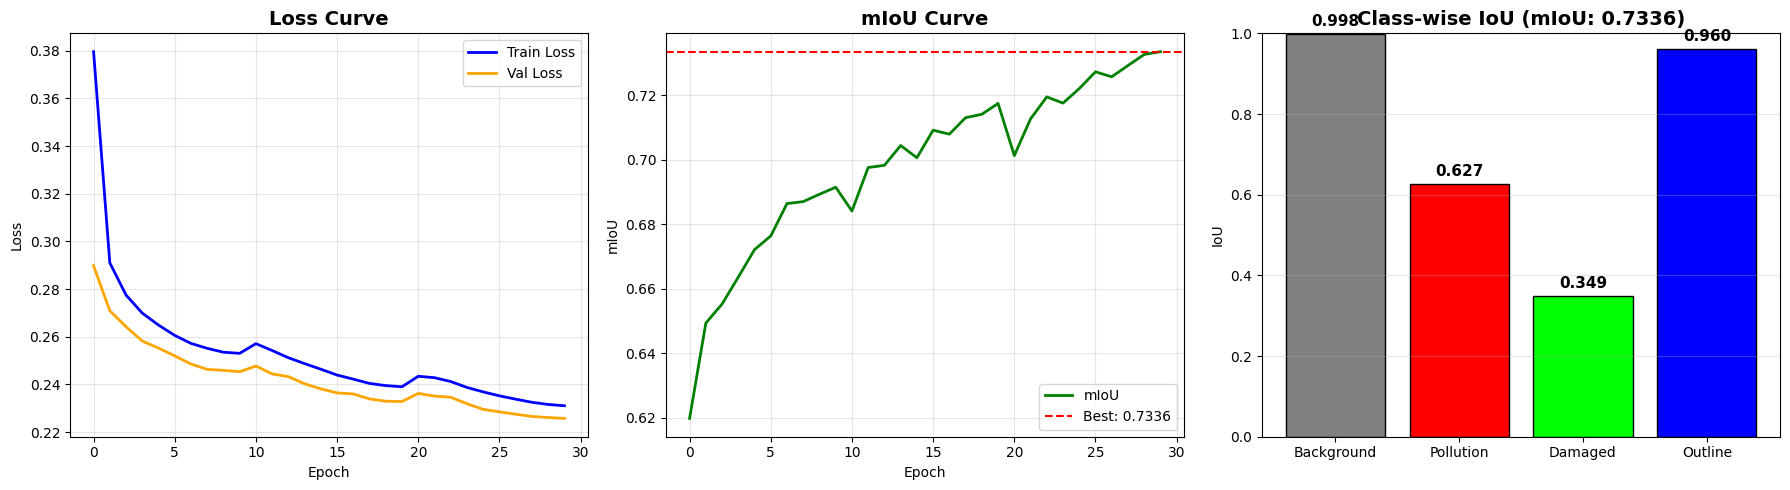

✅ 학습 요약 그래프 저장 완료!


In [ ]:
# ===== [8] 학습 결과 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss Curve
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, color='orange')
axes[0].set_title('Loss Curve', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mIoU Curve
axes[1].plot(history['miou'], label='mIoU', color='green', linewidth=2)
axes[1].axhline(y=best_miou, color='r', linestyle='--', label=f'Best: {best_miou:.4f}')
axes[1].set_title('mIoU Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('mIoU')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 최종 클래스별 IoU (마지막 epoch 기준)
class_names = ['Background', 'Pollution', 'Damaged', 'Outline']
final_miou, final_class_ious = calculate_miou(model, val_loader, device)
colors_bar = ['gray', 'red', 'lime', 'blue']
bars = axes[2].bar(class_names, final_class_ious, color=colors_bar, edgecolor='black')
axes[2].set_title(f'Class-wise IoU (mIoU: {final_miou:.4f})', fontsize=14, fontweight='bold')
axes[2].set_ylabel('IoU')
axes[2].set_ylim(0, 1)
for bar, iou in zip(bars, final_class_ious):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{iou:.3f}', ha='center', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 학습 요약 그래프 저장 완료!")

/tmp/ipython-input-2238323239.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


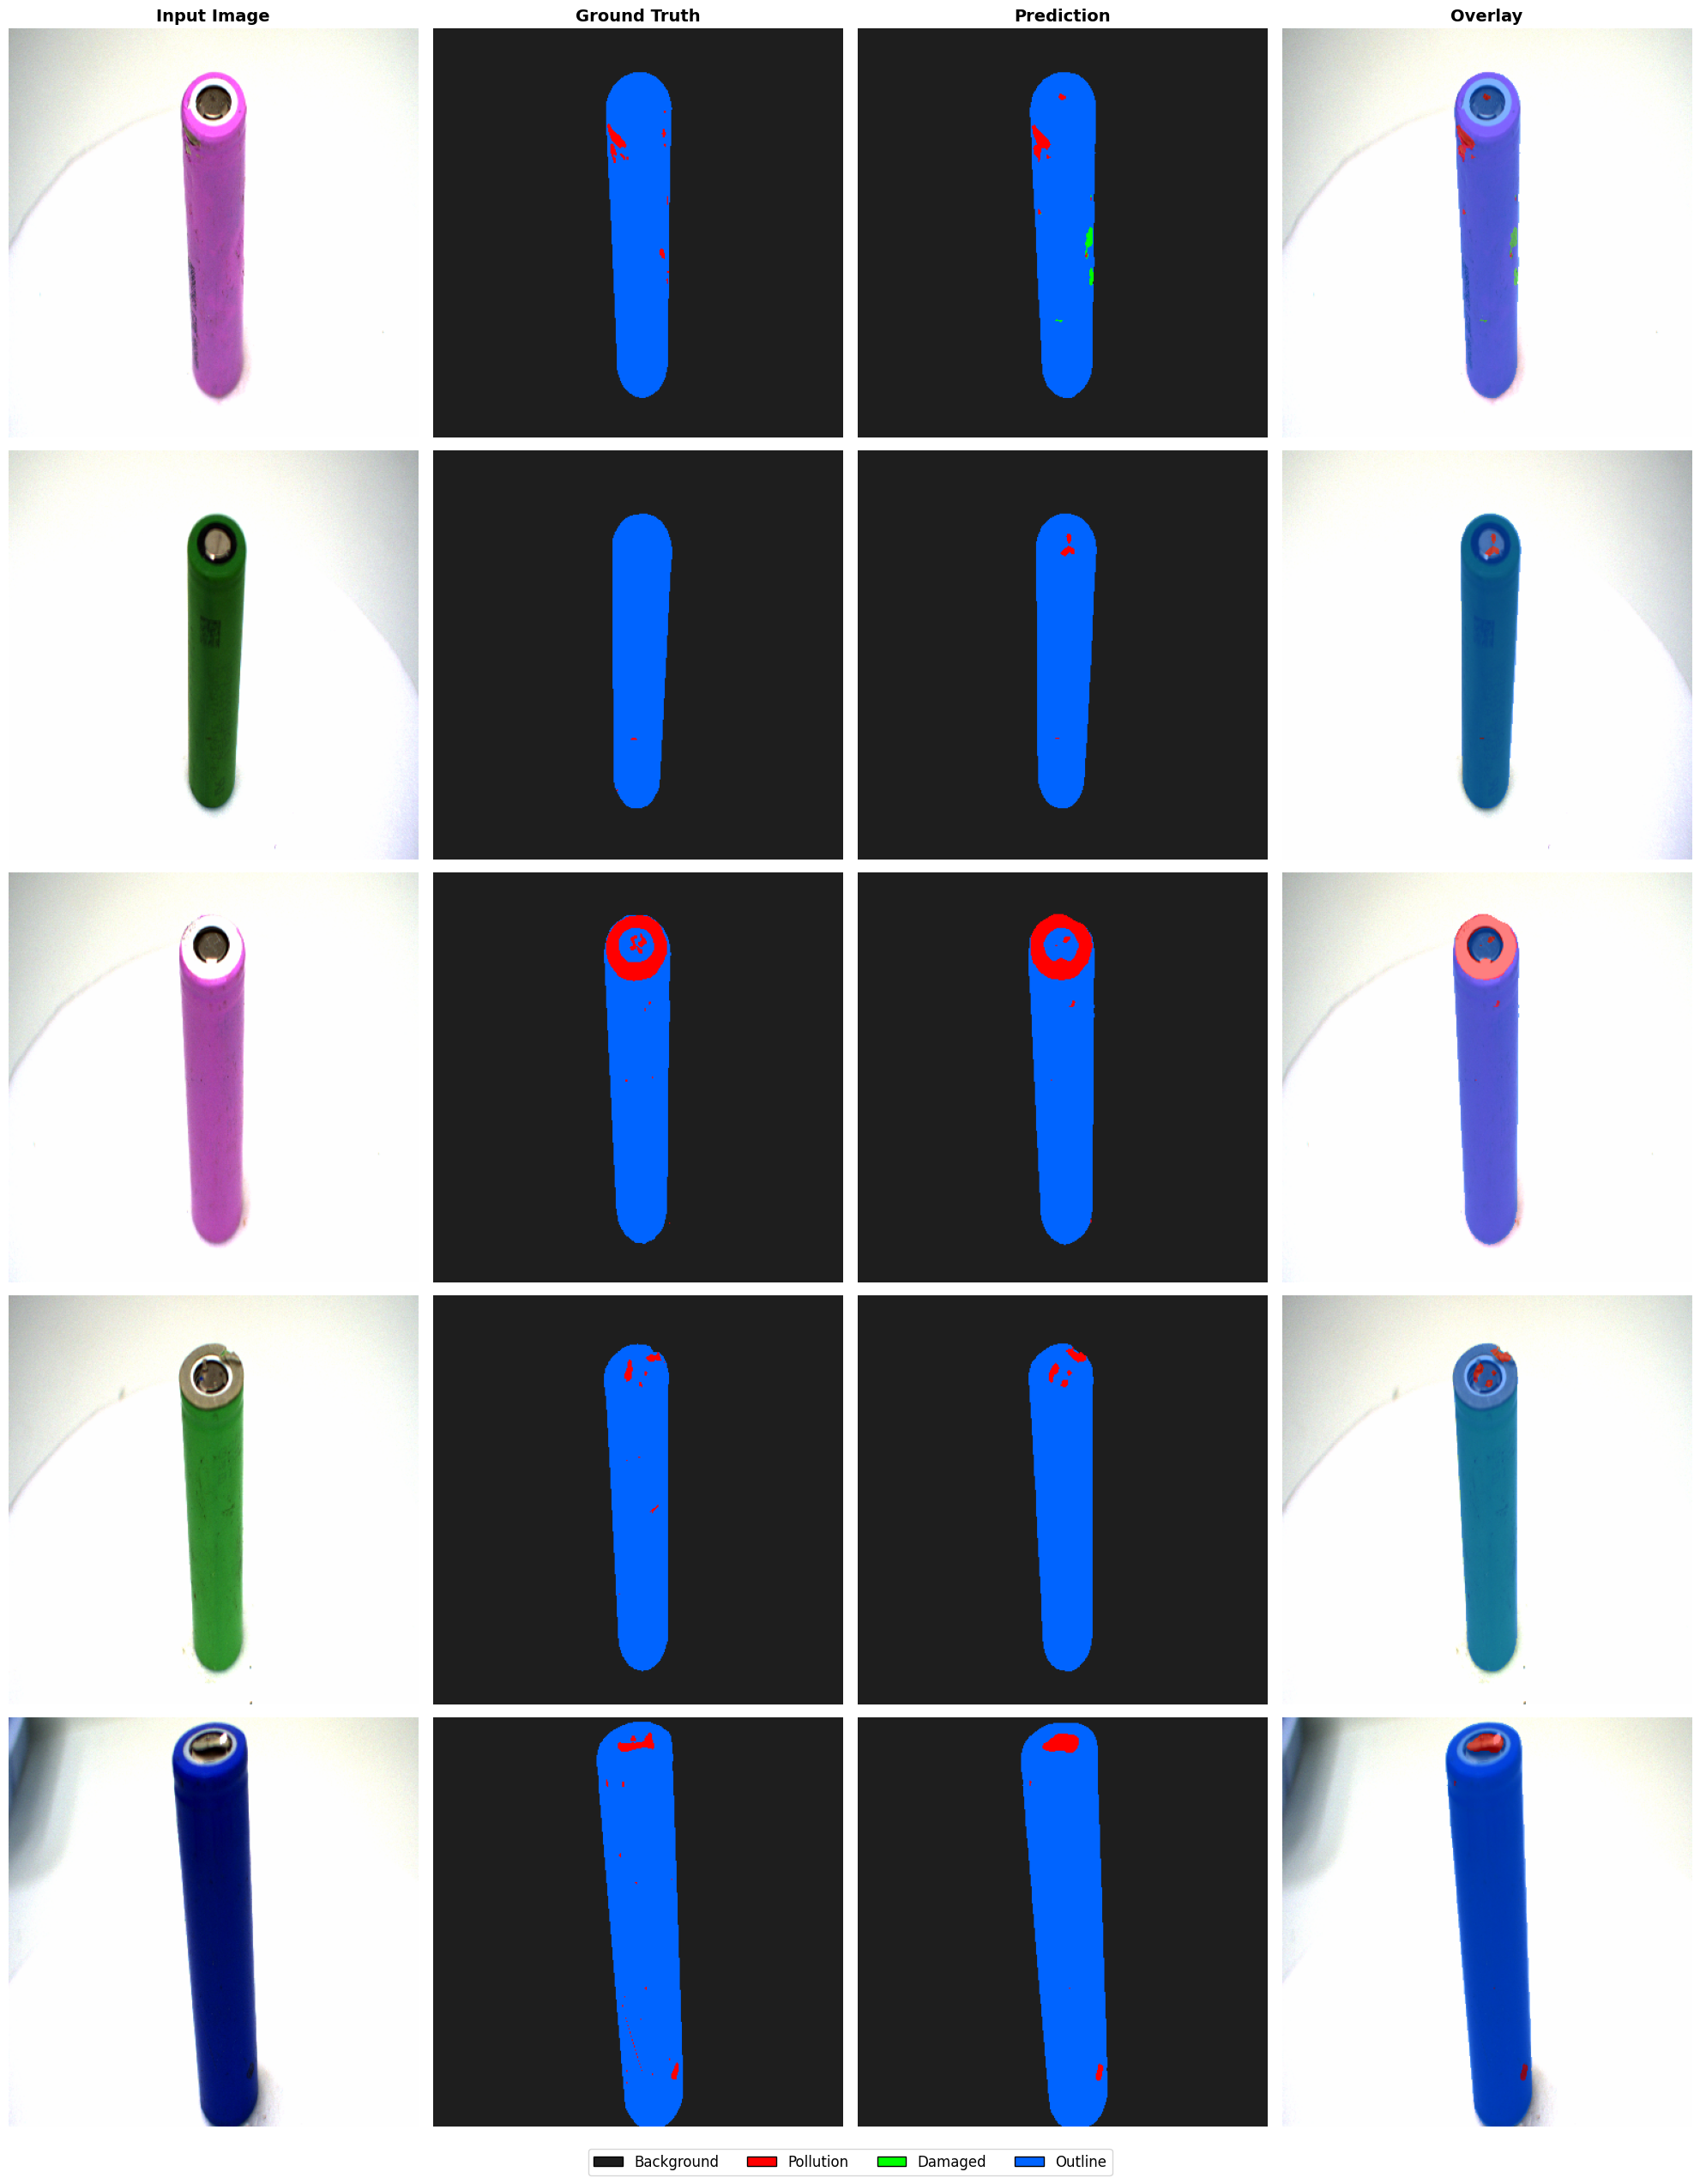

✅ 예측 시각화 저장 완료!


In [ ]:
# ===== [9] 예측 결과 시각화 (5개 샘플) =====
model.load_state_dict(torch.load('best_model_fast.pth'))
model.eval()

# 색상 맵 (클래스별)
class_colors = np.array([
    [30, 30, 30],      # Background - 어두운 회색
    [255, 0, 0],       # Pollution - 빨강
    [0, 255, 0],       # Damaged - 초록
    [0, 100, 255]      # Outline - 파랑
])

fig, axes = plt.subplots(5, 4, figsize=(20, 25))
column_titles = ['Input Image', 'Ground Truth', 'Prediction', 'Overlay']

# 랜덤 샘플 5개 선택
np.random.seed(42)
sample_indices = np.random.choice(len(val_dataset), 5, replace=False)

for i, idx in enumerate(sample_indices):
    img, mask = val_dataset[idx]

    with torch.no_grad(), torch.cuda.amp.autocast():
        pred = torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).cpu().numpy()[0]

    # 원본 이미지 복원
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)

    mask_np = mask.numpy()

    # 컬러 마스크 생성
    gt_color = class_colors[mask_np]
    pred_color = class_colors[pred]

    # Overlay (원본 + 예측)
    overlay = img_np.copy()
    alpha = 0.5
    for cls in range(1, 4):  # Background 제외
        overlay[pred == cls] = (1-alpha) * overlay[pred == cls] + alpha * class_colors[cls]
    overlay = overlay.astype(np.uint8)

    # 그리기
    axes[i, 0].imshow(img_np)
    axes[i, 1].imshow(gt_color)
    axes[i, 2].imshow(pred_color)
    axes[i, 3].imshow(overlay)

    for j in range(4):
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(column_titles[j], fontsize=14, fontweight='bold')

# 범례 추가
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c/255, edgecolor='black', label=n)
                   for c, n in zip(class_colors, class_names)]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=12,
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.savefig('prediction_samples.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 예측 시각화 저장 완료!")

📊 전체 Validation 데이터 분석 중...


  0%|          | 0/279 [00:00<?, ?it/s]/tmp/ipython-input-544833581.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 279/279 [01:50<00:00,  2.52it/s]


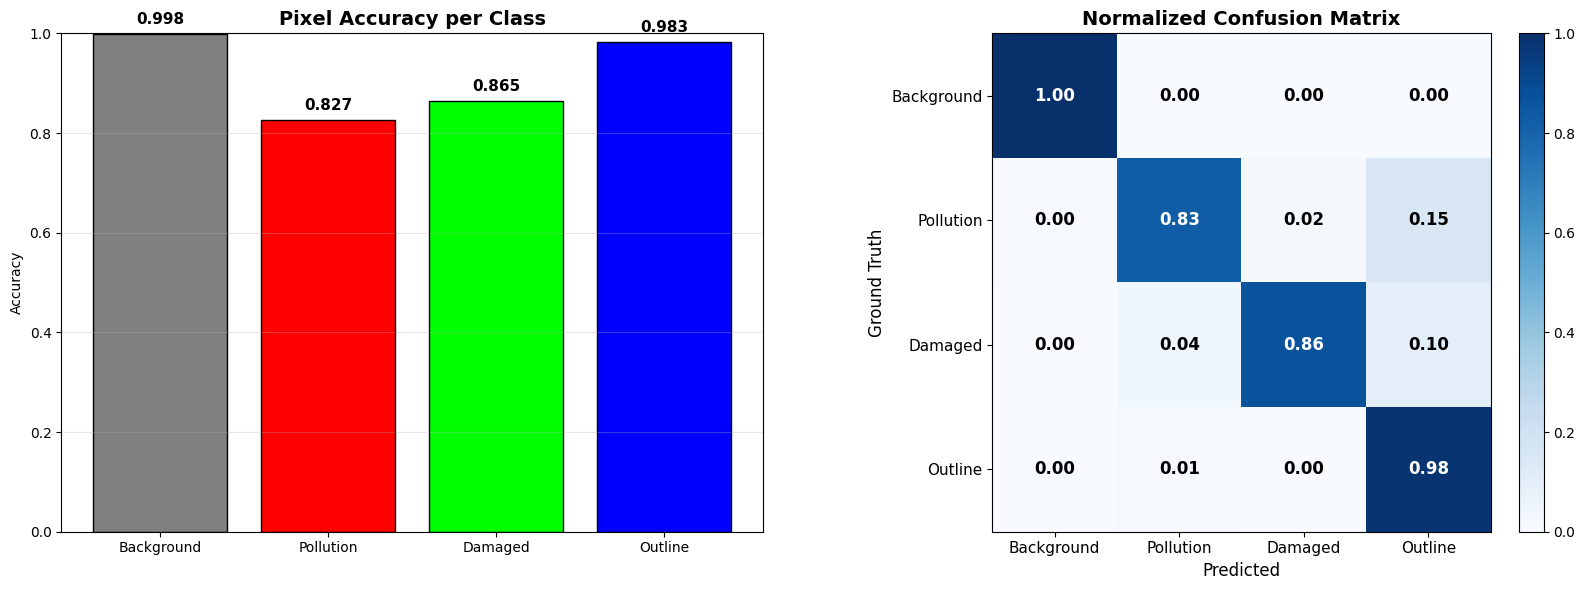


📊 클래스별 분석 결과:
Class        Pixel Acc    IoU          Pixels         
Background   0.9980       0.9977       583,030,338    
Pollution    0.8269       0.6271       3,415,479      
Damaged      0.8646       0.3491       380,793        
Outline      0.9828       0.9603       69,352,590     
Mean         0.9181       0.7336      


In [ ]:
# ===== [10] Confusion Matrix 스타일 분석 =====
from collections import defaultdict

model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)
confusion = np.zeros((4, 4), dtype=np.int64)

print("📊 전체 Validation 데이터 분석 중...")
with torch.no_grad():
    for images, masks in tqdm(val_loader):
        with torch.cuda.amp.autocast():
            preds = torch.argmax(model(images.to(device)), dim=1).cpu().numpy()
        masks = masks.numpy()

        for cls in range(4):
            class_total[cls] += np.sum(masks == cls)
            class_correct[cls] += np.sum((preds == cls) & (masks == cls))

        # Confusion matrix
        for true_cls in range(4):
            for pred_cls in range(4):
                confusion[true_cls, pred_cls] += np.sum((masks == true_cls) & (preds == pred_cls))

# 정규화 (행 기준 - 각 GT 클래스에서 어디로 예측되었는지)
confusion_norm = confusion.astype(float) / confusion.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pixel Accuracy per Class
pixel_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(4)]
bars = axes[0].bar(class_names, pixel_acc, color=colors_bar, edgecolor='black')
axes[0].set_title('Pixel Accuracy per Class', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
for bar, acc in zip(bars, pixel_acc):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.3f}', ha='center', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Confusion Matrix
im = axes[1].imshow(confusion_norm, cmap='Blues', vmin=0, vmax=1)
axes[1].set_xticks(range(4))
axes[1].set_yticks(range(4))
axes[1].set_xticklabels(class_names, fontsize=11)
axes[1].set_yticklabels(class_names, fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Ground Truth', fontsize=12)
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')

# 수치 표시
for i in range(4):
    for j in range(4):
        color = 'white' if confusion_norm[i, j] > 0.5 else 'black'
        axes[1].text(j, i, f'{confusion_norm[i, j]:.2f}', ha='center', va='center',
                     color=color, fontsize=12, fontweight='bold')

plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('analysis_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 클래스별 분석 결과:")
print(f"{'Class':<12} {'Pixel Acc':<12} {'IoU':<12} {'Pixels':<15}")
print("="*50)
for i, name in enumerate(class_names):
    print(f"{name:<12} {pixel_acc[i]:<12.4f} {final_class_ious[i]:<12.4f} {class_total[i]:<15,}")
print("="*50)
print(f"{'Mean':<12} {np.mean(pixel_acc):<12.4f} {final_miou:<12.4f}")

In [ ]:
# ===== [11] 가장 잘된/못된 예측 비교 =====
print("🔍 샘플별 IoU 계산 중...")
sample_ious = []

model.eval()
with torch.no_grad():
    for idx in tqdm(range(len(val_dataset))):
        img, mask = val_dataset[idx]
        with torch.cuda.amp.autocast():
            pred = torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).cpu().numpy()[0]
        mask_np = mask.numpy()

        # 샘플별 mIoU 계산
        ious = []
        for cls in range(4):
            inter = np.sum((pred == cls) & (mask_np == cls))
            union = np.sum((pred == cls) | (mask_np == cls))
            if union > 0:
                ious.append(inter / union)
        sample_ious.append((idx, np.mean(ious) if ious else 0))

# 정렬
sample_ious.sort(key=lambda x: x[1])
worst_5 = sample_ious[:5]
best_5 = sample_ious[-5:][::-1]

def visualize_samples(indices_scores, title):
    fig, axes = plt.subplots(len(indices_scores), 4, figsize=(20, 5*len(indices_scores)))

    for i, (idx, score) in enumerate(indices_scores):
        img, mask = val_dataset[idx]
        with torch.no_grad(), torch.cuda.amp.autocast():
            pred = torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).cpu().numpy()[0]

        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)

        gt_color = class_colors[mask.numpy()]
        pred_color = class_colors[pred]

        # 차이점 하이라이트
        diff = (mask.numpy() != pred).astype(np.uint8) * 255
        diff_color = np.stack([diff, np.zeros_like(diff), np.zeros_like(diff)], axis=-1)

        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f'Input (mIoU: {score:.3f})', fontsize=12)
        axes[i, 1].imshow(gt_color)
        axes[i, 1].set_title('Ground Truth', fontsize=12)
        axes[i, 2].imshow(pred_color)
        axes[i, 2].set_title('Prediction', fontsize=12)
        axes[i, 3].imshow(diff_color)
        axes[i, 3].set_title('Errors (Red)', fontsize=12)

        for j in range(4):
            axes[i, j].axis('off')

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Best 5
fig_best = visualize_samples(best_5, '🏆 Best 5 Predictions')
plt.savefig('best_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# Worst 5
fig_worst = visualize_samples(worst_5, '⚠️ Worst 5 Predictions')
plt.savefig('worst_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Best/Worst 예측 시각화 완료!")